**User Input and Image Generation**

Steps with Gradio:
1. Ask User for Image Concepts: Use Gradio to create a text input interface where users can enter their image concepts.
2. Clean User Input: Ensure the prompt is clean of unnecessary spaces or characters.
3. Prompt the Image Generation Agent: Call APIs to generate images using Stable Diffusion XL and DALL-E based on user input.

In [25]:
# Import Dependencies
import requests
import base64
from PIL import Image
from io import BytesIO
import gradio as gr
import os
from dotenv import load_dotenv
import openai

In [26]:
# Load environment variables.
load_dotenv()

# Store the API key in a variable.
NVIDIA_API_KEY = os.getenv("NVIDIA_API_KEY")
openai.api_key = os.getenv("OPENAI_API_KEY")


# Set the model name for our LLMs.
OPENAI_MODEL = "gpt-3.5-turbo"

In [27]:
# Call NVidia's Stable Diffusion API and generate an image
def generate_stable_diffusion_image(prompt):
    url = "https://ai.api.nvidia.com/v1/genai/stabilityai/stable-diffusion-xl"

    payload = {
        "height": 1024,
        "width": 1024,
        "text_prompts": [
            {
                "text": prompt,
                "weight": 1
            }
        ],
        "cfg_scale": 5,
        "clip_guidance_preset": "NONE",
        "sampler": "K_DPM_2_ANCESTRAL",
        "samples": 1,
        "seed": 0,
        "steps": 25,
        "style_preset": "none"
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": "Bearer " + NVIDIA_API_KEY
    }

    return requests.post(url, json=payload, headers=headers)

In [28]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def view_base64_image(base64_string):
    """Decodes a base64 encoded image and displays it using matplotlib."""

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

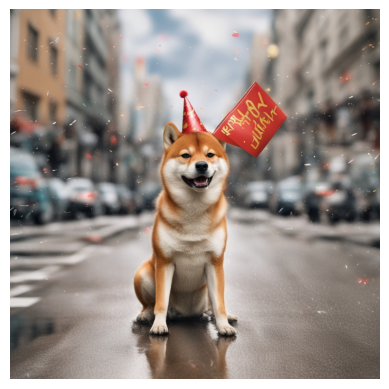

In [29]:
# Testing Nvidia API
response = generate_stable_diffusion_image("A realistic image of a shiba inu with a birthday hat on the street")
imgdata = response.json()['artifacts'][0]['base64']
# Example usage
base64_image = imgdata
view_base64_image(base64_image)

In [30]:
# Clean user input by removing extra spaces
def clean_user_input(user_query):
    cleaned_query = ' '.join(user_query.split())
    return cleaned_query

In [31]:
# Call Stable Diffusion API and generate an image
#def call_stable_diffusion_api(prompt):
#    response = requests.post('https://api.stablediffusion.com/generate', json={'prompt': prompt})
#    image_data = base64.b64decode(response.json()['image'])
#    return Image.open(BytesIO(image_data))

In [32]:
from openai import OpenAI

# Call DALL-E API and generate an image
def call_dalle_api(prompt):
    client = OpenAI()
    response = client.images.generate(
    model="dall-e-2",
    prompt=prompt,
    size="512x512",
    quality="standard",
    n=1,
    response_format="b64_json"
    )

    return response.data[0]
    #response = requests.post('https://api.dalle.com/generate', json={'prompt': prompt})
    #image_data = base64.b64decode(response.json()['image'])
    #return Image.open(BytesIO(image_data))

In [33]:
response = call_dalle_api("A realistic image of a shiba inu with a birthday hat on the street")

In [34]:
response.b64_json

'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAAbGVYSWZNTQAqAAAACAACknwAAgAAAC0AAAAmkoYAAgAAABgAAABUAAAAAE9wZW5BSS0tcmVxXzFhN2E4ODI5MTc4ZDAwNTIxYzlmOGU4MDNlNTI1MDliAABNYWRlIHdpdGggT3BlbkFJIERBTEwtRQA9zpqAAAEAAElEQVR4AQAWhOl7AScwFQABAv4B/QUGAgIDAv4BAAD//gYGA/8A/gcBBPwC/f79/AAFAv78/f39/wD+//78/f39//79//79/gEAAgD8AwL7Av/+//z8/v8BAP8BAAIEAAIGAgABAAQDBAIGAAQEAgIFAAQGBf/+/wIAAv3//v4A/QD9BP37+QT/APv7/P///wECAQABAwEDAf7+AAEEA///AgD//gMEAwABAf/8/v7+/f8AAAH///8CAwAA/gIAAP4CAAH+/gICAP77/P4AAQH//gAAAgMDA/z9/QD8+//8AgEB//79/v/+AQEAAv7//wL/AwIBAPz9/wAD/wABAQEBAgEGAAEEAAMGBAEC/wEDAgIB/gAA/gMEAP4B/v7//gYDBv7+/v/+Af7/AQL+//78/gIFBf39/wD+/v8BAvz9+gH9AQEAAgABAP/8/gH+Av8AAP8B/gECAQAAAv////7//wYGA/z8/QEBAP8CAQIBAv/7/P8B/wIBAgACAP35/gEDAwAA/wIDAwD/AP3+AP/+/AMAAwACAP7/AP/9/QIAAf8BAQH9/wMDBP0A/gIBAAIEAgD+/QMDBP4A/f79APz9/AECBP/7/wIEAv8A/wQEBP0A/QD+/gYGBf79AQEFAgL//vz/AP///QH+Af0BAgEA/QUAAQICAQEBA/r+AP3+/QH+/wYEBAUDAP7+/QABAP79AAMEA//+/v8B////Av/+/AIBAv7+Avf3+QD8Afz/AAD//gEA//79//8BAwUEBPwA/wUJAggQBgoOBQQIBQI

In [35]:
# Convert base64 string to a PIL Image object
def base64_to_pil_image(base64_string):

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Create a BytesIO object from the decoded data
    image_bytes = BytesIO(image_data)

    # Open the image using PIL
    image = Image.open(image_bytes)

    return image

In [36]:

# Generate images and assess their quality
def generate_images_with_quality(prompt):
    cleaned_prompt = clean_user_input(prompt)
    sd_image = base64_to_pil_image(generate_stable_diffusion_image(prompt).json()['artifacts'][0]['base64'])
    dalle_image = base64_to_pil_image(call_dalle_api(cleaned_prompt).b64_json)
    #sd_quality = assess_image_quality(sd_image)
    #dalle_quality = assess_image_quality(dalle_image)
    return sd_image, dalle_image #, f"Quality: {sd_quality}", dalle_image, f"Quality: {dalle_quality}"

In [37]:
# Gradio interface setup for user interaction
iface = gr.Interface(fn=generate_images_with_quality,
                     inputs="text",
                     outputs=[gr.Image(type="pil", label="SD Image"), gr.Image(type="pil", label="DallE Image")],
                     title="Text-to-Image Generation",
                     description="Input a concept to generate images using DALL-E and Stable Diffusion.")

iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://357ac7772e7049ec00.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Image Preprocessing and Quality Assessment**

Steps:
1. Measure Image Quality: Preprocess images to evaluate their quality using a classifier.

In [38]:
# Import Dependencies
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier

In [39]:
# Preprocess the image for quality assessment
def preprocess_image(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(gray_image, (256, 256))  # Resize image
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image.flatten()

In [40]:
# Replace with actual trained model for real use case
image_quality_classifier = RandomForestClassifier()

In [41]:
# Assess the quality of an image using a classifier
def assess_image_quality(image):
    feature_vector = preprocess_image(image)
    quality_score = image_quality_classifier.predict([feature_vector])[0]
    return quality_score

**Image Evaluation, Relevance Check, and Description Generation**

Steps:
1. Evaluate Image Relevance: Use an LLM to assess whether the generated image is relevant to the prompt.
2. Generate Image Descriptions: Use a classifier to create descriptive summaries of the images.
3. Compare Models: Analyze how each model's output aligns with the user query.

In [42]:
# Import dependencies
import openai

# Imports for loading environment variables.
from dotenv import load_dotenv
import os

In [43]:
# Evaluate the relevance of an image using LLM
def evaluate_image_relevance(prompt, image):
    evaluation_result = llm_evaluate(prompt, image)
    relevance_score = compare_with_prompt(evaluation_result, prompt)
    return relevance_score

In [44]:
# Use LLM for evaluating relevance based on prompt and image data
def llm_evaluate(prompt, image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    response = openai.Completion.create(
      engine="text-davinci-003",
      prompt=f"Evaluate the relevance of this image based on the prompt: {prompt}. Image data: {img_str}",
      max_tokens=50
    )
    
    return response.choices[0].text.strip()

In [45]:
# Compare LLM evaluation result with original prompt
def compare_with_prompt(evaluation_result, prompt):
    return "Relevant" if "relevant" in evaluation_result.lower() else "Not Relevant"

In [46]:
# Generate description
def generate_description(image):
    # Placeholder for a model that generates descriptions from images
    description_model_output = "A detailed description of the image."
    return description_model_output

**Data Handling with Pandas**

Steps:
1. Store Results: Use Pandas to handle data and store results in a structured format for analysis.

In [47]:
# Import dependencies
import pandas as pd

In [48]:
# Create a DataFrame to store results of generation and evaluation
results_df = pd.DataFrame(columns=['Prompt', 'SD_Image_Quality', 'DALL_E_Image_Quality', 'SD_Relevance', 'DALL_E_Relevance'])

In [49]:
# Simulated values for debugging
prompt = "A futuristic cityscape"
sd_quality = 8
dalle_quality = 7
sd_relevance = "Relevant"
dalle_relevance = "Not Relevant"

# Adding data using pd.concat instead of append
new_row = pd.DataFrame([{ 
    'Prompt': prompt, 
    'SD_Image_Quality': sd_quality, 
    'DALL_E_Image_Quality': dalle_quality, 
    'SD_Relevance': sd_relevance,
    'DALL_E_Relevance': dalle_relevance
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df

,Prompt,SD_Image_Quality,DALL_E_Image_Quality,SD_Relevance,DALL_E_Relevance
0,A futuristic cityscape,8,7,Relevant,Not Relevant


In [50]:
# Save results into CSV file for further analysis or reporting
results_df.to_csv('image_generation_results.csv', index=False)